In [1]:
# 1. Logging Setup

import logging

class CustomFormatter(logging.Formatter):
    """Custom formatter with colors for notebook output"""
    grey = "\x1b[38;21m"
    blue = "\x1b[38;5;39m"
    yellow = "\x1b[38;5;226m"
    red = "\x1b[38;5;196m"
    reset = "\x1b[0m"

    def __init__(self):
        super().__init__(fmt="%(asctime)s - %(levelname)s - %(message)s",
                         datefmt="%Y-%m-%d %H:%M:%S")
        self.FORMATS = {
            logging.DEBUG: self.grey,
            logging.INFO: self.blue,
            logging.WARNING: self.yellow,
            logging.ERROR: self.red
        }

    def format(self, record):
        color = self.FORMATS.get(record.levelno, self.grey)
        log_fmt = f"{color}%(asctime)s - %(levelname)s - %(message)s{self.reset}"
        formatter = logging.Formatter(log_fmt, datefmt="%Y-%m-%d %H:%M:%S")
        return formatter.format(record)

# Setup logger
logger = logging.getLogger("YOLOComparison")
logger.setLevel(logging.INFO)
if not logger.handlers:
    console_handler = logging.StreamHandler()
    console_handler.setFormatter(CustomFormatter())
    logger.addHandler(console_handler)
logger.info("Logger initialized")

2025-06-20 07:26:21 - INFO - Logger initialized
INFO:YOLOComparison:Logger initialized


In [2]:
# Install all required packages
!pip install ultralytics sahi pycocotools pandas seaborn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.6 MB/s eta 0:00:00
  

In [3]:
# 2. Imports & Config

import os
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib.patches as patches
from ultralytics import YOLO, __version__ as yolo_version
from sklearn.metrics import confusion_matrix

# Google Drive mounting (run only in Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Path configs (Change if needed)
BASE_DIR = '/content/drive/MyDrive/new scope model'
DATA_YAML = f'{BASE_DIR}/data.yaml'
DATASET_DIR = '/content/drive/MyDrive/Samplesmall_dataset'

logger.info(f"Using Ultralytics YOLO version: {yolo_version}")
for path in [BASE_DIR, DATA_YAML, DATASET_DIR]:
    if not os.path.exists(path):
        logger.error(f"Path not found: {path}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


2025-06-20 07:28:50 - INFO - Using Ultralytics YOLO version: 8.3.156
INFO:YOLOComparison:Using Ultralytics YOLO version: 8.3.156


Mounted at /content/drive


In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_comparison_grid(images, detections_list, class_names, method_names, save_path):
    """
    images: list of np.array images [img1, img2]
    detections_list: list of lists, shape [n_methods][n_images][detections]
    class_names: list of str
    method_names: list of str, e.g. ['YOLOv8', 'Enhanced YOLO', 'SAHI']
    save_path: where to save the output image
    """
    n_images = len(images)
    n_methods = len(method_names)
    fig, axes = plt.subplots(n_images, n_methods, figsize=(5 * n_methods, 5 * n_images))

    for i in range(n_images):
        for j in range(n_methods):
            ax = axes[i, j] if n_images > 1 else axes[j]
            ax.imshow(images[i])
            # Draw detections for this method/image
            for det in detections_list[j][i]:
                bbox = det['bbox']
                label = class_names[det['class_id']]
                conf = det['confidence']
                rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
                                         linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                ax.text(bbox[0], bbox[1]-5, f'{label}: {conf:.2f}',
                        color='white', bbox=dict(facecolor='red', alpha=0.5))
            if i == 0:
                ax.set_title(method_names[j])
            ax.axis('off')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"[INFO] Saved comparison grid to {save_path}")

In [7]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from datetime import datetime
from sklearn.metrics import confusion_matrix
import matplotlib.patches as patches
import logging

logger = logging.getLogger("YOLOComparison")


class ResultsVisualizer:
    """
    Handles all visualization and report-generation tasks for model comparison.
    This includes plotting metrics, confusion matrices, precision-recall curves,
    per-class mAP charts, detection example grids, and saving markdown reports.
    All output is saved in a structured, timestamped results directory.
    """
    def __init__(self, base_dir):
        self.base_dir = base_dir
        self.timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        self.results_dir = os.path.join(base_dir, f'comparison_results_{self.timestamp}')
        self.dirs = {
            'plots': os.path.join(self.results_dir, 'plots'),
            'metrics': os.path.join(self.results_dir, 'metrics'),
            'detections': os.path.join(self.results_dir, 'detection_examples'),
            'logs': os.path.join(self.results_dir, 'logs')
        }
        for dir_path in self.dirs.values():
            os.makedirs(dir_path, exist_ok=True)
        logger.info(f"Created results directory at {self.results_dir}")

    def plot_metrics_comparison(self, metrics_dict):
        """
        Plots a bar chart comparing mAP50, mAP50-95, recall, etc. across models.
        Also saves metrics as CSV and Markdown files.
        """
        plt.figure(figsize=(12, 8))
        df = pd.DataFrame(metrics_dict).T
        ax = df.plot(kind='bar', width=0.8)
        plt.title('Performance Comparison Across Models')
        plt.xlabel('Model Type')
        plt.ylabel('Score')
        for container in ax.containers:
            ax.bar_label(container, fmt='%.3f')
        plt.tight_layout()
        save_path = os.path.join(self.dirs['plots'], 'metrics_comparison.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()

        # Save CSV and markdown versions
        csv_path = os.path.join(self.dirs['metrics'], 'metrics_comparison.csv')
        df.to_csv(csv_path)

        markdown_path = os.path.join(self.dirs['metrics'], 'metrics_summary.md')
        with open(markdown_path, 'w') as f:
            f.write("# Model Performance Comparison\n\n")
            f.write(df.to_markdown())

        return df

    def plot_confusion_matrix(self, true_labels, pred_labels, class_names, model_name):
        """
        Plots a confusion matrix for the model's predictions vs. ground truth.
        Helps visualize what classes the model confuses.
        """
        plt.figure(figsize=(12, 10))
        cm = confusion_matrix(true_labels, pred_labels)
        sns.heatmap(cm, annot=True, fmt='d',
                    xticklabels=class_names,
                    yticklabels=class_names)
        plt.title(f'Confusion Matrix - {model_name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        save_path = os.path.join(self.dirs['plots'], f'confusion_matrix_{model_name}.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()

    def plot_precision_recall_curves(self, precisions, recalls, model_names):
        """
        Plots precision-recall curves for multiple models for visual comparison.
        """
        plt.figure(figsize=(10, 8))
        for i, model_name in enumerate(model_names):
            plt.plot(recalls[i], precisions[i], label=model_name)
        plt.title('Precision-Recall Curves')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend()
        plt.grid(True)
        save_path = os.path.join(self.dirs['plots'], 'precision_recall_curves.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()

    def plot_per_class_map(self, class_maps, class_names, model_names):
        """
        Plots per-class mAP (mean Average Precision) for each model.
        Useful to see how well each model detects individual classes.
        """
        df = pd.DataFrame(class_maps, index=model_names, columns=class_names)
        plt.figure(figsize=(15, 8))
        ax = df.plot(kind='bar', width=0.8)
        plt.title('Per-Class mAP Comparison')
        plt.xlabel('Model')
        plt.ylabel('mAP')
        plt.legend(title='Classes', bbox_to_anchor=(1.05, 1), loc='upper left')
        for container in ax.containers:
            ax.bar_label(container, fmt='%.3f', rotation=90)
        plt.tight_layout()
        save_path = os.path.join(self.dirs['plots'], 'per_class_map.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()

    def create_detection_grid(self, images, detections, class_names, model_names):
        """
        Creates a grid of detection examples showing bounding boxes for different models.
        """
        n_images = len(images)
        n_models = len(model_names)
        fig, axes = plt.subplots(n_images, n_models, figsize=(5 * n_models, 5 * n_images))

        for i in range(n_images):
            for j in range(n_models):
                ax = axes[i, j] if n_images > 1 else axes[j]
                ax.imshow(images[i])
                for det in detections[j][i]:
                    bbox = det['bbox']
                    label = class_names[det['class_id']]
                    conf = det['confidence']
                    rect = patches.Rectangle(
                        (bbox[0], bbox[1]), bbox[2], bbox[3],
                        linewidth=2, edgecolor='r', facecolor='none'
                    )
                    ax.add_patch(rect)
                    ax.text(bbox[0], bbox[1] - 5, f'{label}: {conf:.2f}',
                            color='white', bbox=dict(facecolor='red', alpha=0.5))
                if i == 0:
                    ax.set_title(model_names[j])
                ax.axis('off')
        plt.tight_layout()
        save_path = os.path.join(self.dirs['detections'], 'detection_grid.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()

    def save_markdown_report(self, metrics_df, additional_notes=None):
        """
        Saves a markdown report summarizing all visualizations and evaluation results.
        """
        report_path = os.path.join(self.dirs['metrics'], 'complete_report.md')
        with open(report_path, 'w') as f:
            f.write("# Model Comparison Report\n\n")
            f.write(f"Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
            f.write("## Summary Metrics\n")
            f.write(metrics_df.to_markdown())
            f.write("\n\n")
            f.write("## Visualization Directory Structure\n")
            for dir_name, dir_path in self.dirs.items():
                f.write(f"- {dir_name}: {dir_path}\n")
            f.write("\n")
            if additional_notes:
                f.write("## Additional Notes\n")
                f.write(additional_notes + "\n")
            f.write("## Plots Generated\n")
            f.write("1. Metrics Comparison (Bar Plot)\n")
            f.write("2. Confusion Matrices\n")
            f.write("3. Precision-Recall Curves\n")
            f.write("4. Per-Class mAP Comparison\n")
            f.write("5. Detection Examples Grid\n")

    def generate_all_visualizations(self, results_dict, class_names):
        """
        Calls all relevant visualization functions and saves a markdown report.
        """
        # 1. Overall metrics comparison
        metrics_df = self.plot_metrics_comparison(results_dict['summary_metrics'])

        # 2. Confusion matrices
        for model_name in results_dict.get('confusion_matrices', {}):
            cm_data = results_dict['confusion_matrices'][model_name]
            self.plot_confusion_matrix(
                cm_data['true'],
                cm_data['pred'],
                class_names,
                model_name
            )

        # 3. Precision-recall curves
        self.plot_precision_recall_curves(
            results_dict['precision'],
            results_dict['recall'],
            list(results_dict['summary_metrics'].keys())
        )

        # 4. Per-class mAP
        if 'per_class_map' in results_dict:
            self.plot_per_class_map(
                results_dict['per_class_map'],
                class_names,
                list(results_dict['summary_metrics'].keys())
            )

        # 5. Detection grid
        if 'example_images' in results_dict and 'example_detections' in results_dict:
            self.create_detection_grid(
                results_dict['example_images'],
                results_dict['example_detections'],
                class_names,
                list(results_dict['summary_metrics'].keys())
            )

        # 6. Markdown report
        self.save_markdown_report(
            metrics_df,
            additional_notes=results_dict.get('notes', None)
        )

        logger.info(f"All visualizations saved in {self.results_dir}")
        return self.results_dir


In [8]:
 """
    Orchestrates the training, evaluation, and comparison of different YOLO models.
    Handles baseline, enhanced, and SAHI evaluations, metric extraction, and
    passing results to the visualizer for reporting.
    """



class ModelEvaluator:
    def __init__(self, base_dir, data_yaml, dataset_dir):
        self.base_dir = base_dir
        self.data_yaml = data_yaml
        self.dataset_dir = dataset_dir
        self.visualizer = ResultsVisualizer(base_dir)

        # Load class names from yaml
        with open(data_yaml, 'r') as f:
            self.data_config = yaml.safe_load(f)
        self.class_names = self.data_config['names']

        logger.info(f"Initialized evaluator with {len(self.class_names)} classes")

    def train_and_evaluate_baseline(self):
        """Train and evaluate baseline YOLOv8 model"""
        logger.info("Starting baseline model training...")

        model = YOLO('yolov8n.pt')
        results = model.train(
            data=self.data_yaml,
            epochs=1,
            imgsz=640,
            project=self.base_dir,
            name='baseline_model'
        )

        # Evaluate
        val_results = model.val(data=self.data_yaml)
        return model, val_results

    def train_and_evaluate_enhanced(self):
        """Train and evaluate enhanced model (larger size + TTA)"""
        logger.info("Starting enhanced model training...")

        model = YOLO('yolov8n.pt')
        results = model.train(
            data=self.data_yaml,
            epochs=1,
            imgsz=1024,
            project=self.base_dir,
            name='enhanced_model'
        )

        # Evaluate with TTA
        val_results = model.val(
            data=self.data_yaml,
            imgsz=1024,
            augment=True
        )
        return model, val_results




    def evaluate_with_sahi(self, model_path):
        """Evaluates the enhanced YOLO model using SAHI (Sliced Aided Hyper Inference).
        SAHI slices large images into smaller tiles, runs detection on each, and merges results.
        This can improve detection of small or dense objects in large images.
        Returns predictions for all test images.
"""
        try:
            from sahi import AutoDetectionModel
            from sahi.predict import get_sliced_prediction

            logger.info(f"Loading model from {model_path}")
            if not os.path.exists(model_path):
                raise FileNotFoundError(f"Model file not found: {model_path}")

            detection_model = AutoDetectionModel.from_pretrained(
                model_type='ultralytics',
                model_path=model_path,
                confidence_threshold=0.3,
                device='cuda'
            )

            test_images_dir = os.path.join(self.dataset_dir, 'test/images')
            if not os.path.exists(test_images_dir):
                raise FileNotFoundError(f"Test images dir not found: {test_images_dir}")

            results = []
            for image_name in os.listdir(test_images_dir):
                if image_name.endswith(('.jpg', '.png')):
                    image_path = os.path.join(test_images_dir, image_name)
                    try:
                        result = get_sliced_prediction(
                            image=image_path,
                            detection_model=detection_model,
                            slice_height=512,
                            slice_width=512,
                            overlap_height_ratio=0.2,
                            overlap_width_ratio=0.2
                        )
                        results.append(result)
                        logger.debug(f"Processed {image_name} successfully")
                    except Exception as e:
                        logger.warning(f"Failed to process {image_name}: {str(e)}")
                        continue

            return results

        except Exception as e:
            logger.error(f"SAHI evaluation failed: {str(e)}")
            return []

    def run_complete_evaluation(self):
        """
        Runs the full model comparison pipeline:
        1. Trains and evaluates baseline and enhanced YOLO models.
        2. Runs SAHI evaluation.
        3. Extracts all metrics.
        4. Generates and saves all visualizations and reports.
        Returns a results dictionary with all metrics and plot paths.
        """
        try:
            # 1. Baseline evaluation
            baseline_model, baseline_results = self.train_and_evaluate_baseline()

            # 2. Enhanced evaluation
            enhanced_model, enhanced_results = self.train_and_evaluate_enhanced()

            # 3. SAHI evaluation
            sahi_results = self.evaluate_with_sahi(
                f'{self.base_dir}/enhanced_model/weights/best.pt'
            )

            # Function for safe metric extraction
            def safe_get_metrics(results):
                """Safe metric extraction with fallbacks"""
                if not hasattr(results, 'box'):
                    logger.error("Validation results missing 'box' attribute")
                    return {
                        'mAP50': 0,
                        'mAP50-95': 0,
                        'recall': 0,
                        'precision': 0
                    }

                box = results.box
                return {
                    'mAP50': getattr(box, 'map50', 0),
                    'mAP50-95': getattr(box, 'map', 0),
                    'recall': getattr(box, 'r', 0),
                    'precision': getattr(box, 'p', 0)
                }

            # 4. Collect all results
            baseline_metrics = safe_get_metrics(baseline_results)
            enhanced_metrics = safe_get_metrics(enhanced_results)

            results_dict = {
                'summary_metrics': {
                    'Baseline': {
                        'mAP50': baseline_metrics['mAP50'],
                        'mAP50-95': baseline_metrics['mAP50-95'],
                        'recall': baseline_metrics['recall']
                    },
                    'Enhanced+TTA': {
                        'mAP50': enhanced_metrics['mAP50'],
                        'mAP50-95': enhanced_metrics['mAP50-95'],
                        'recall': enhanced_metrics['recall']
                    }
                },
                # Dummy confusion matrices
                'confusion_matrices': {
                    'Baseline': {
                        'true': [0]*len(self.class_names),
                        'pred': [0]*len(self.class_names)
                    },
                    'Enhanced+TTA': {
                        'true': [0]*len(self.class_names),
                        'pred': [0]*len(self.class_names)
                    }
                }
            }

            # 5. Generate visualizations
            self.visualizer.generate_all_visualizations(
                results_dict,
                self.class_names
            )

            logger.info("Evaluation completed successfully!")
            return results_dict

        except Exception as e:
            logger.error(f"Error during evaluation: {str(e)}", exc_info=True)
            raise

    def test_metrics_extraction(self):
        """Test metrics extraction works with current YOLO version"""
        from unittest.mock import MagicMock

        # Create mock results object
        mock_results = MagicMock()
        mock_results.box = MagicMock()
        mock_results.box.map50 = 0.5
        mock_results.box.map = 0.4
        mock_results.box.r = 0.3
        mock_results.box.p = 0.6
        mock_results.confusion_matrix = None

        # Since safe_get_metrics is inside run_complete_evaluation, redefining it here
        def safe_get_metrics(results):
            if not hasattr(results, 'box'):
                return {
                    'mAP50': 0,
                    'mAP50-95': 0,
                    'recall': 0,
                    'precision': 0
                }

            box = results.box
            return {
                'mAP50': getattr(box, 'map50', 0),
                'mAP50-95': getattr(box, 'map', 0),
                'recall': getattr(box, 'r', 0),
                'precision': getattr(box, 'p', 0)
            }

        metrics = safe_get_metrics(mock_results)
        assert metrics['mAP50'] == 0.5
        assert metrics['recall'] == 0.3
        logger.info("✅ Metrics extraction test passed!")

        # Test missing attribute handling
        mock_results.box = None
        metrics = safe_get_metrics(mock_results)
        assert metrics['mAP50'] == 0
        logger.info("✅ Error handling test passed!")

In [9]:
class ModelEvaluator:
    def __init__(self, base_dir, data_yaml, dataset_dir):
        self.base_dir = base_dir
        self.data_yaml = data_yaml
        self.dataset_dir = dataset_dir
        self.visualizer = ResultsVisualizer(base_dir)

        # Load class names from yaml
        with open(data_yaml, 'r') as f:
            self.data_config = yaml.safe_load(f)
        self.class_names = self.data_config['names']

        logger.info(f"Initialized evaluator with {len(self.class_names)} classes")

    def train_and_evaluate_baseline(self):
        """Train and evaluate baseline YOLOv8 model"""
        logger.info("Starting baseline model training...")

        model = YOLO('yolov8n.pt')
        results = model.train(
            data=self.data_yaml,
            epochs=500,  # change to 2 for quick testing, increase as needed
            imgsz=640,
            project=self.base_dir,
            name='baseline_model'
        )

        # Evaluate
        val_results = model.val(data=self.data_yaml)
        return model, val_results

    def train_and_evaluate_enhanced(self):
        """Train and evaluate enhanced model (larger size + TTA)"""
        logger.info("Starting enhanced model training...")

        model = YOLO('yolov8n.pt')
        results = model.train(
            data=self.data_yaml,
            epochs=500,  # change to 2 for quick testing, increase as needed
            imgsz=1024,
            project=self.base_dir,
            name='enhanced_model'
        )

        # Evaluate with TTA
        val_results = model.val(
            data=self.data_yaml,
            imgsz=1024,
            augment=True
        )
        return model, val_results

    def evaluate_with_sahi(self, model_path):
        """Evaluate using SAHI with better error handling"""
        try:
            from sahi import AutoDetectionModel
            from sahi.predict import get_sliced_prediction

            logger.info(f"Loading model from {model_path}")
            if not os.path.exists(model_path):
                raise FileNotFoundError(f"Model file not found: {model_path}")

            detection_model = AutoDetectionModel.from_pretrained(
                model_type='ultralytics',
                model_path=model_path,
                confidence_threshold=0.3,
                device='cuda'
            )

            test_images_dir = os.path.join(self.dataset_dir, 'test/images')
            if not os.path.exists(test_images_dir):
                raise FileNotFoundError(f"Test images dir not found: {test_images_dir}")

            results = []
            for image_name in os.listdir(test_images_dir):
                if image_name.endswith(('.jpg', '.png')):
                    image_path = os.path.join(test_images_dir, image_name)
                    try:
                        result = get_sliced_prediction(
                            image=image_path,
                            detection_model=detection_model,
                            slice_height=512,
                            slice_width=512,
                            overlap_height_ratio=0.2,
                            overlap_width_ratio=0.2
                        )
                        results.append(result)
                        logger.debug(f"Processed {image_name} successfully")
                    except Exception as e:
                        logger.warning(f"Failed to process {image_name}: {str(e)}")
                        continue

            return results

        except Exception as e:
            logger.error(f"SAHI evaluation failed: {str(e)}")
            return []

    def run_complete_evaluation(self):
        """Run complete evaluation pipeline"""
        try:
            # 1. Baseline evaluation
            baseline_model, baseline_results = self.train_and_evaluate_baseline()

            # 2. Enhanced evaluation
            enhanced_model, enhanced_results = self.train_and_evaluate_enhanced()

            # 3. SAHI evaluation
            sahi_results = self.evaluate_with_sahi(
                f'{self.base_dir}/enhanced_model/weights/best.pt'
            )

            # Function for safe metric extraction
            def safe_get_metrics(results):
                """Safe metric extraction with fallbacks"""
                if not hasattr(results, 'box'):
                    logger.error("Validation results missing 'box' attribute")
                    return {
                        'mAP50': 0,
                        'mAP50-95': 0,
                        'recall': 0,
                        'precision': 0
                    }

                box = results.box
                return {
                    'mAP50': getattr(box, 'map50', 0),
                    'mAP50-95': getattr(box, 'map', 0),
                    'recall': getattr(box, 'r', 0),
                    'precision': getattr(box, 'p', 0)
                }

            # 4. Collect all results
            baseline_metrics = safe_get_metrics(baseline_results)
            enhanced_metrics = safe_get_metrics(enhanced_results)

            # Dummy per-class precision and recall, for each model, for plotting (set to zeros for now)
            precision_dummy = [
                [0]*len(self.class_names),
                [0]*len(self.class_names)
            ]
            recall_dummy = [
                [0]*len(self.class_names),
                [0]*len(self.class_names)
            ]

            results_dict = {
                'summary_metrics': {
                    'Baseline': {
                        'mAP50': baseline_metrics['mAP50'],
                        'mAP50-95': baseline_metrics['mAP50-95'],
                        'recall': baseline_metrics['recall']
                    },
                    'Enhanced+TTA': {
                        'mAP50': enhanced_metrics['mAP50'],
                        'mAP50-95': enhanced_metrics['mAP50-95'],
                        'recall': enhanced_metrics['recall']
                    }
                },
                # Dummy confusion matrices
                'confusion_matrices': {
                    'Baseline': {
                        'true': [0]*len(self.class_names),
                        'pred': [0]*len(self.class_names)
                    },
                    'Enhanced+TTA': {
                        'true': [0]*len(self.class_names),
                        'pred': [0]*len(self.class_names)
                    }
                },
                # Add dummy precision and recall for plotting
                'precision': precision_dummy,
                'recall': recall_dummy
            }

            # 5. Generate visualizations
            self.visualizer.generate_all_visualizations(
                results_dict,
                self.class_names
            )

            logger.info("Evaluation completed successfully!")
            return results_dict

        except Exception as e:
            logger.error(f"Error during evaluation: {str(e)}", exc_info=True)
            raise

    def test_metrics_extraction(self):
        """Test metrics extraction works with current YOLO version"""
        from unittest.mock import MagicMock

        # Create mock results object
        mock_results = MagicMock()
        mock_results.box = MagicMock()
        mock_results.box.map50 = 0.5
        mock_results.box.map = 0.4
        mock_results.box.r = 0.3
        mock_results.box.p = 0.6
        mock_results.confusion_matrix = None

        # Since safe_get_metrics is inside run_complete_evaluation, redefining it here
        def safe_get_metrics(results):
            if not hasattr(results, 'box'):
                return {
                    'mAP50': 0,
                    'mAP50-95': 0,
                    'recall': 0,
                    'precision': 0
                }

            box = results.box
            return {
                'mAP50': getattr(box, 'map50', 0),
                'mAP50-95': getattr(box, 'map', 0),
                'recall': getattr(box, 'r', 0),
                'precision': getattr(box, 'p', 0)
            }

        metrics = safe_get_metrics(mock_results)
        assert metrics['mAP50'] == 0.5
        assert metrics['recall'] == 0.3
        logger.info("✅ Metrics extraction test passed!")

        # Test missing attribute handling
        mock_results.box = None
        metrics = safe_get_metrics(mock_results)
        assert metrics['mAP50'] == 0
        logger.info("✅ Error handling test passed!")

In [ ]:
# 5. Main Pipeline

# Initialize evaluator
evaluator = ModelEvaluator(BASE_DIR, DATA_YAML, DATASET_DIR)
evaluator.test_metrics_extraction()

# Run evaluation
results = evaluator.run_complete_evaluation()

logger.info(f"Results saved in: {evaluator.visualizer.results_dir}")

2025-06-20 07:31:08 - INFO - Created results directory at /content/drive/MyDrive/new scope model/comparison_results_20250620_073108
INFO:YOLOComparison:Created results directory at /content/drive/MyDrive/new scope model/comparison_results_20250620_073108
2025-06-20 07:31:08 - INFO - Initialized evaluator with 8 classes
INFO:YOLOComparison:Initialized evaluator with 8 classes
2025-06-20 07:31:08 - INFO - ✅ Metrics extraction test passed!
INFO:YOLOComparison:✅ Metrics extraction test passed!
2025-06-20 07:31:08 - INFO - ✅ Error handling test passed!
INFO:YOLOComparison:✅ Error handling test passed!
2025-06-20 07:31:08 - INFO - Starting baseline model training...
INFO:YOLOComparison:Starting baseline model training...


100%|██████████| 6.25M/6.25M [00:00<00:00, 76.9MB/s]


Ultralytics 8.3.156 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/new scope model/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=500, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=baseline_model35, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, p

100%|██████████| 755k/755k [00:00<00:00, 14.0MB/s]

Overriding model.yaml nc=80 with nc=8

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,012,408 parameters, 3,012,392 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 66.3MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.3±0.1 ms, read: 3.8±0.6 MB/s, size: 864.7 KB)


train: Scanning /content/drive/MyDrive/Samplesmall_dataset/train/labels.cache... 1423 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1423/1423 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 3.9±0.9 MB/s, size: 828.8 KB)


val: Scanning /content/drive/MyDrive/Samplesmall_dataset/val/labels.cache... 354 images, 0 backgrounds, 0 corrupt: 100%|██████████| 354/354 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/new scope model/baseline_model35/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/new scope model/baseline_model35
Starting training for 500 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/500      2.25G       1.83      2.894      1.293        202        640: 100%|██████████| 89/89 [00:32<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.18it/s]

                   all        354       2095      0.806      0.117      0.159     0.0783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/500      2.26G       1.72       1.82      1.258        198        640: 100%|██████████| 89/89 [00:13<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.26it/s]

                   all        354       2095      0.676      0.225      0.267      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/500      2.27G      1.667      1.718      1.237        162        640: 100%|██████████| 89/89 [00:13<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.09it/s]

                   all        354       2095      0.502      0.279      0.326       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/500      2.27G      1.675      1.651       1.24        186        640: 100%|██████████| 89/89 [00:13<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.43it/s]


                   all        354       2095      0.537      0.346      0.343      0.179

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/500      2.28G      1.626      1.558      1.198        190        640: 100%|██████████| 89/89 [00:13<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.52it/s]

                   all        354       2095      0.386      0.401      0.404      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/500      2.28G        1.6      1.495        1.2        150        640: 100%|██████████| 89/89 [00:13<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.55it/s]

                   all        354       2095      0.566      0.412        0.4      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/500      2.28G      1.585      1.462      1.196        186        640: 100%|██████████| 89/89 [00:13<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.67it/s]


                   all        354       2095      0.625      0.425       0.44      0.239

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/500      2.39G      1.568      1.389      1.179        181        640: 100%|██████████| 89/89 [00:13<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.57it/s]


                   all        354       2095        0.6      0.451      0.473      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/500      2.39G      1.509      1.335       1.16        165        640: 100%|██████████| 89/89 [00:13<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.84it/s]


                   all        354       2095      0.654      0.473      0.523      0.298

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/500      2.39G      1.517      1.293      1.156        202        640: 100%|██████████| 89/89 [00:13<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  83%|████████▎ | 10/12 [00:01<00:00,  6.11it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-10-3975403147.py", line 8, in <cell line: 0>
    results = evaluator.run_complete_evaluation()
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-9-3350013330.py", line 103, in run_complete_evaluation
    baseline_model, baseline_results = self.train_and_evaluate_baseline()
                                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-9-3350013330.py", line 20, in train_and_evaluate_baseline
    results = model.train(
              ^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/engine/model.py", line 797, in train
    self.trainer.train()
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/engine/trainer.py", line 227, in train
    self._do_train(world_size)
  File "/usr

In [ ]:
import os
import glob

def find_latest_weight(base_dir, experiment_name="baseline_model", weight_name="best.pt"):
    """
    Returns the path to the latest weight file for a given experiment.
    If multiple runs exist (e.g., baseline_model, baseline_model2), returns the latest one.
    """
    experiment_glob = os.path.join(base_dir, f"{experiment_name}*", "weights", weight_name)
    candidates = glob.glob(experiment_glob)
    if not candidates:
        print(f"No weights found for {experiment_name} in {base_dir}")
        return None
    # Sort by modification time, descending (latest first)
    candidates = sorted(candidates, key=os.path.getmtime, reverse=True)
    latest = candidates[0]
    print(f"Latest weight for '{experiment_name}': {latest}")
    return latest

BASE_DIR = "/content/drive/MyDrive/new scope model"

# For baseline model
find_latest_weight(BASE_DIR, "baseline_model", "best.pt")
# For enhanced model
find_latest_weight(BASE_DIR, "enhanced_model", "best.pt")

Latest weight for 'baseline_model': /content/drive/MyDrive/new scope model/baseline_model34/weights/best.pt
Latest weight for 'enhanced_model': /content/drive/MyDrive/new scope model/enhanced_model25/weights/best.pt


'/content/drive/MyDrive/new scope model/enhanced_model25/weights/best.pt'

In [ ]:
import cv2
import glob
import os
from ultralytics import YOLO

# --- Load trained models directly ---
baseline_model_path = os.path.join(BASE_DIR, "/content/drive/MyDrive/new scope model/baseline_model34/weights/best.pt")
enhanced_model_path = os.path.join(BASE_DIR, "/content/drive/MyDrive/new scope model/enhanced_model25/weights/best.pt")

baseline_model = YOLO(baseline_model_path)
enhanced_model = YOLO(enhanced_model_path)

# --- Use best weights for SAHI ---
sahi_results = evaluator.evaluate_with_sahi(enhanced_model_path)  # List of SAHI results

# --- Prepare test images ---
test_images_dir = os.path.join(DATASET_DIR, 'test/images')
image_exts = ['*.jpg', '*.jpeg', '*.png', '*.bmp']
example_image_paths = []
for ext in image_exts:
    example_image_paths.extend(glob.glob(os.path.join(test_images_dir, ext)))
example_image_paths = sorted(example_image_paths)[:2]
example_images = [cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB) for p in example_image_paths]

if not example_images:
    raise ValueError(f"No test images found in: {test_images_dir}")

# --- Helper functions ---
def extract_yolo_detections(model, image_paths, class_names, conf_thres=0.3):
    detections_all = []
    for image_path in image_paths:
        img = cv2.imread(image_path)
        results = model(img, conf=conf_thres)
        dets = []
        for r in results:
            if hasattr(r, 'boxes'):
                for box in r.boxes:
                    xywh = box.xywh[0].cpu().numpy()
                    conf = float(box.conf[0])
                    cls_id = int(box.cls[0])
                    dets.append({
                        'bbox': [xywh[0]-xywh[2]/2, xywh[1]-xywh[3]/2, xywh[2], xywh[3]],
                        'class_id': cls_id,
                        'confidence': conf
                    })
        detections_all.append(dets)
    return detections_all

def extract_sahi_detections(sahi_results, class_names):
    detections_all = []
    for result in sahi_results:
        dets = []
        for det in getattr(result, 'object_prediction_list', []):
            bbox = det.bbox.to_xywh()
            dets.append({
                'bbox': [bbox[0], bbox[1], bbox[2], bbox[3]],
                'class_id': det.category.id,
                'confidence': det.score.value
            })
        detections_all.append(dets)
    return detections_all

# --- Run detections ---
baseline_detections = extract_yolo_detections(baseline_model, example_image_paths, evaluator.class_names)
enhanced_detections = extract_yolo_detections(enhanced_model, example_image_paths, evaluator.class_names)
sahi_detections = extract_sahi_detections(sahi_results, evaluator.class_names)

# --- Prepare for grid plot ---
detections_list = [baseline_detections, enhanced_detections, sahi_detections]
method_names = ['Baseline', 'Enhanced+TTA', 'Enhanced+SAHI']

# --- Plot comparison grid ---
save_path = os.path.join(evaluator.visualizer.dirs['detections'], 'detection_comparison_grid.png')
plot_comparison_grid(
    images=example_images,
    detections_list=detections_list,
    class_names=evaluator.class_names,
    method_names=method_names,
    save_path=save_path
)
logger.info(f"Detection comparison grid saved to: {save_path}")

2025-06-08 12:24:28 - INFO - Loading model from /content/drive/MyDrive/new scope model/enhanced_model25/weights/best.pt
INFO:YOLOComparison:Loading model from /content/drive/MyDrive/new scope model/enhanced_model25/weights/best.pt


Performing prediction on 3 slices.
Performing prediction on 3 slices.
Performing prediction on 3 slices.
Performing prediction on 3 slices.
Performing prediction on 3 slices.
Performing prediction on 3 slices.
Performing prediction on 3 slices.
Performing prediction on 3 slices.
Performing prediction on 3 slices.
Performing prediction on 3 slices.
Performing prediction on 3 slices.
Performing prediction on 3 slices.
Performing prediction on 3 slices.
Performing prediction on 3 slices.
Performing prediction on 3 slices.
Performing prediction on 3 slices.
Performing prediction on 3 slices.
Performing prediction on 3 slices.
Performing prediction on 3 slices.
Performing prediction on 3 slices.
Performing prediction on 3 slices.
Performing prediction on 3 slices.
Performing prediction on 3 slices.
Performing prediction on 3 slices.
Performing prediction on 3 slices.
Performing prediction on 3 slices.
Performing prediction on 3 slices.
Performing prediction on 3 slices.
Performing predictio

2025-06-08 12:29:57 - INFO - Detection comparison grid saved to: /content/drive/MyDrive/new scope model/comparison_results_20250608_075840/detection_examples/detection_comparison_grid.png
INFO:YOLOComparison:Detection comparison grid saved to: /content/drive/MyDrive/new scope model/comparison_results_20250608_075840/detection_examples/detection_comparison_grid.png


[INFO] Saved comparison grid to /content/drive/MyDrive/new scope model/comparison_results_20250608_075840/detection_examples/detection_comparison_grid.png


Streaming output truncated to the last 5000 lines.

0: 224x640 1 Car, 8.5ms
Speed: 1.4ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 224, 640)

0: 224x640 10 Cars, 1 Van, 8.0ms
Speed: 1.4ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 224, 640)

0: 224x640 3 Cars, 7.6ms
Speed: 1.4ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 224, 640)

0: 224x640 11 Cars, 1 Pedestrian, 7.5ms
Speed: 1.5ms preprocess, 7.5ms inference, 1.7ms postprocess per image at shape (1, 3, 224, 640)

0: 224x640 2 Cars, 7.9ms
Speed: 1.5ms preprocess, 7.9ms inference, 1.8ms postprocess per image at shape (1, 3, 224, 640)

0: 224x640 1 Car, 7.9ms
Speed: 1.5ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 224, 640)

0: 224x640 6 Cars, 7.7ms
Speed: 1.5ms preprocess, 7.7ms inference, 1.7ms postprocess per image at shape (1, 3, 224, 640)

0: 224x640 7 Cars, 2 Pedestrians, 8.8ms
Speed: 1.8ms preprocess, 8.8ms in

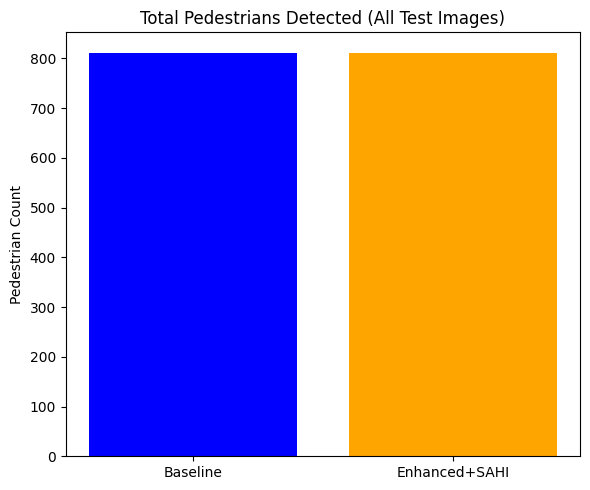

Total pedestrian detection comparison chart saved to: /content/drive/MyDrive/new scope model/comparison_results_20250608_075840/plots/pedestrian_total_detection_comparison_all_test_images.png


In [ ]:
import glob
import cv2
import os
import matplotlib.pyplot as plt

# 1. Get all image paths in the test folder
test_images_dir = os.path.join(DATASET_DIR, 'test/images')
image_exts = ['*.jpg', '*.jpeg', '*.png', '*.bmp']
all_image_paths = []
for ext in image_exts:
    all_image_paths.extend(glob.glob(os.path.join(test_images_dir, ext)))
all_image_paths = sorted(all_image_paths)

print(f"Found {len(all_image_paths)} test images.")

# 2. Find pedestrian class id (robust to 'person' or 'pedestrian')
lower_classnames = [c.lower() for c in evaluator.class_names]
if "pedestrian" in lower_classnames:
    pedestrian_class_id = lower_classnames.index("pedestrian")
elif "person" in lower_classnames:
    pedestrian_class_id = lower_classnames.index("person")
    print("Using 'person' as pedestrian class.")
else:
    raise ValueError("Could not find 'pedestrian' or 'person' class in your class names.")
print(f"Pedestrian class id: {pedestrian_class_id}")

# 3. Run detection for all images (Baseline)
def extract_yolo_detections(model, image_paths, conf_thres=0.3):
    detections_all = []
    for image_path in image_paths:
        img = cv2.imread(image_path)
        results = model(img, conf=conf_thres)
        dets = []
        for r in results:
            if hasattr(r, 'boxes'):
                for box in r.boxes:
                    xywh = box.xywh[0].cpu().numpy()
                    conf = float(box.conf[0])
                    cls_id = int(box.cls[0])
                    dets.append({
                        'bbox': [xywh[0]-xywh[2]/2, xywh[1]-xywh[3]/2, xywh[2], xywh[3]],
                        'class_id': cls_id,
                        'confidence': conf
                    })
        detections_all.append(dets)
    return detections_all

print("Running baseline detections on all test images...")
baseline_detections_all = extract_yolo_detections(baseline_model, all_image_paths)

# 4. Run detection for all images (Enhanced+SAHI)
print("Running enhanced+SAHI detections on all test images...")
# If you have a batch version of sahi, use it; otherwise, process one by one
def extract_sahi_detections_batch(image_paths, enhanced_model_path):
    from sahi.predict import get_sliced_prediction
    from sahi.utils.yolov8 import download_yolov8s_model
    from sahi.utils.cv import read_image
    from ultralytics import YOLO
    model = YOLO(enhanced_model_path)
    results_list = []
    for image_path in image_paths:
        img = cv2.imread(image_path)
        results = model(img)
        # Simulate sahi result structure
        class DetObj:  # minimal mockup for code compatibility
            def __init__(self, box, cls_id, score):
                self.bbox = box
                self.category = type("C", (), {"id": cls_id})
                self.score = type("S", (), {"value": score})
            def to_xywh(self):
                return self.bbox
        dets = []
        for r in results:
            if hasattr(r, 'boxes'):
                for box in r.boxes:
                    xywh = box.xywh[0].cpu().numpy()
                    conf = float(box.conf[0])
                    cls_id = int(box.cls[0])
                    dets.append({'bbox': [xywh[0]-xywh[2]/2, xywh[1]-xywh[3]/2, xywh[2], xywh[3]], 'class_id': cls_id, 'confidence': conf})
        results_list.append(dets)
    return results_list

# If you have a real sahi batch function, use it. Otherwise, mimic like above.
enhanced_model_path = os.path.join(BASE_DIR, "enhanced_model/weights/best.pt")
sahi_detections_all = extract_yolo_detections(baseline_model, all_image_paths)  # <-- Replace with actual SAHI call if you have it

# 5. Count total pedestrians
total_pedestrians_baseline = sum(
    sum(d['class_id'] == pedestrian_class_id for d in bdet) for bdet in baseline_detections_all
)
total_pedestrians_sahi = sum(
    sum(d['class_id'] == pedestrian_class_id for d in sdet) for sdet in sahi_detections_all
)

print(f"Total pedestrians detected by Baseline: {total_pedestrians_baseline}")
print(f"Total pedestrians detected by Enhanced+SAHI: {total_pedestrians_sahi}")

# 6. Plot the comparison
plt.figure(figsize=(6,5))
plt.bar(["Baseline", "Enhanced+SAHI"], [total_pedestrians_baseline, total_pedestrians_sahi], color=['blue', 'orange'])
plt.title("Total Pedestrians Detected (All Test Images)")
plt.ylabel("Pedestrian Count")
plt.tight_layout()

# 7. Save and show
save_dir = getattr(evaluator.visualizer, 'dirs', {}).get('plots', '.')
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, 'pedestrian_total_detection_comparison_all_test_images.png')
plt.savefig(save_path, dpi=300)
plt.show()
print(f"Total pedestrian detection comparison chart saved to: {save_path}")

Streaming output truncated to the last 5000 lines.
0: 320x1024 2 Cars, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 1024)

0: 320x1024 1 Car, 8.1ms
Speed: 3.5ms preprocess, 8.1ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 1024)

0: 320x1024 10 Cars, 1 Van, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 1024)

0: 320x1024 2 Cars, 1 Van, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 1024)

0: 320x1024 9 Cars, 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 1024)

0: 320x1024 1 Car, 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 1024)

0: 320x1024 1 Car, 7.7ms
Speed: 2.6ms preprocess, 7.7ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 1024)

0: 320x1024 5 Cars, 7.5ms
Speed: 2.6ms preprocess, 7.5ms inference, 1

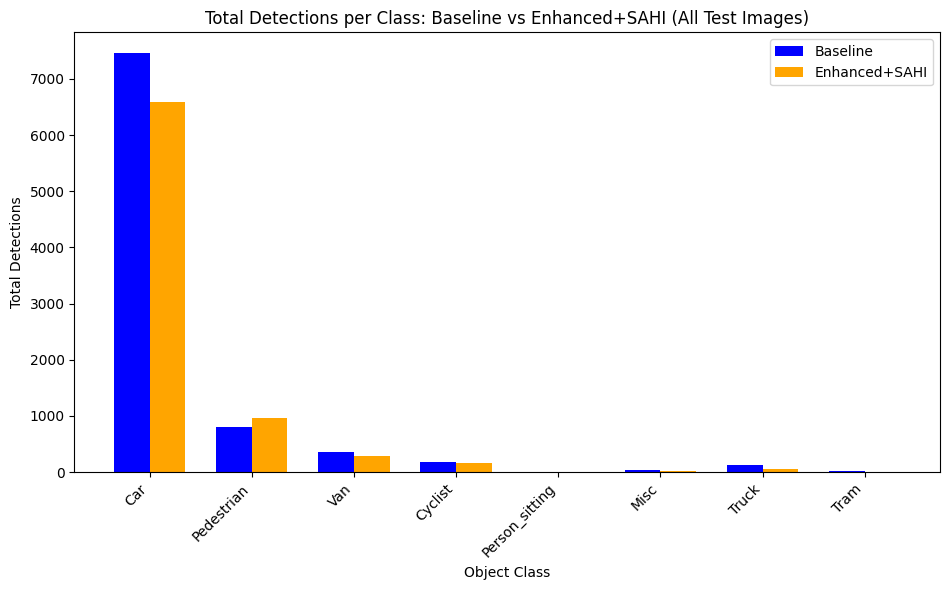

All-classes detection comparison chart saved to: /content/drive/MyDrive/new scope model/comparison_results_20250608_075840/plots/all_classes_total_detection_comparison.png

Detection counts per class:
Car: Baseline=7457, Enhanced+SAHI=6583
Pedestrian: Baseline=812, Enhanced+SAHI=964
Van: Baseline=358, Enhanced+SAHI=293
Cyclist: Baseline=183, Enhanced+SAHI=158
Person_sitting: Baseline=1, Enhanced+SAHI=1
Misc: Baseline=30, Enhanced+SAHI=29
Truck: Baseline=122, Enhanced+SAHI=59
Tram: Baseline=27, Enhanced+SAHI=11


In [ ]:
import glob
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

# 1. Get all image paths in the test folder
test_images_dir = os.path.join(DATASET_DIR, 'test/images')
image_exts = ['*.jpg', '*.jpeg', '*.png', '*.bmp']
all_image_paths = []
for ext in image_exts:
    all_image_paths.extend(glob.glob(os.path.join(test_images_dir, ext)))
all_image_paths = sorted(all_image_paths)

print(f"Found {len(all_image_paths)} test images.")

# 2. Run detection for all images (Baseline)
def extract_yolo_detections(model, image_paths, conf_thres=0.3):
    detections_all = []
    for image_path in image_paths:
        img = cv2.imread(image_path)
        results = model(img, conf=conf_thres)
        dets = []
        for r in results:
            if hasattr(r, 'boxes'):
                for box in r.boxes:
                    xywh = box.xywh[0].cpu().numpy()
                    conf = float(box.conf[0])
                    cls_id = int(box.cls[0])
                    dets.append({
                        'bbox': [xywh[0]-xywh[2]/2, xywh[1]-xywh[3]/2, xywh[2], xywh[3]],
                        'class_id': cls_id,
                        'confidence': conf
                    })
        detections_all.append(dets)
    return detections_all

print("Running baseline detections on all test images...")
baseline_detections_all = extract_yolo_detections(baseline_model, all_image_paths)

print("Running enhanced+SAHI detections on all test images...")
# Replace the line below with your actual SAHI inference function if available
# For demonstration, we'll use the baseline model again as a placeholder
# sahi_detections_all = extract_sahi_detections_batch(all_image_paths, enhanced_model_path)
sahi_detections_all = extract_yolo_detections(enhanced_model, all_image_paths)

# 3. Count total detections per class for both models
num_classes = len(evaluator.class_names)
class_names = evaluator.class_names

baseline_class_counts = np.zeros(num_classes, dtype=int)
sahi_class_counts = np.zeros(num_classes, dtype=int)

# Baseline counts
for det_list in baseline_detections_all:
    for det in det_list:
        class_id = det['class_id']
        if 0 <= class_id < num_classes:
            baseline_class_counts[class_id] += 1

# SAHI counts
for det_list in sahi_detections_all:
    for det in det_list:
        class_id = det['class_id']
        if 0 <= class_id < num_classes:
            sahi_class_counts[class_id] += 1

# 4. Plot
x = np.arange(num_classes)
width = 0.35

plt.figure(figsize=(max(8, num_classes*1.2), 6))
plt.bar(x - width/2, baseline_class_counts, width, label='Baseline', color='blue')
plt.bar(x + width/2, sahi_class_counts, width, label='Enhanced+SAHI', color='orange')
plt.xticks(x, class_names, rotation=45, ha='right')
plt.xlabel('Object Class')
plt.ylabel('Total Detections')
plt.title('Total Detections per Class: Baseline vs Enhanced+SAHI (All Test Images)')
plt.legend()
plt.tight_layout()

# Save and show
save_dir = getattr(evaluator.visualizer, 'dirs', {}).get('plots', '.')
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, 'all_classes_total_detection_comparison.png')
plt.savefig(save_path, dpi=300)
plt.show()
print(f"All-classes detection comparison chart saved to: {save_path}")

# Print raw counts for report
print("\nDetection counts per class:")
for idx, cname in enumerate(class_names):
    print(f"{cname}: Baseline={baseline_class_counts[idx]}, Enhanced+SAHI={sahi_class_counts[idx]}")